# The JAX emulator: CIGALE prototype
In this notebook, I will prototype my idea for emulating radiative transfer codes with a Deepnet in order for it to be used inside xidplus. As `numpyro` uses JAX, the Deepnet wil ideally be trained with a JAX network. I will use CIGALE

In [1]:
import fitIR
import fitIR.models as models
import fitIR.analyse as analyse
from astropy.cosmology import WMAP9 as cosmo
import jax
import numpy as onp
import pylab as plt
import astropy.units as u
import scipy.integrate as integrate
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 
import matplotlib.pyplot as plt # visualization
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Read in CIGALE SEDs

In [136]:
from astropy.io import fits
from astropy.table import Table

### Generate values for CIGALE

In [181]:
onp.array2string(10.0**np.arange(-2.5,0.77,0.02), separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

'[0.0032,0.0033,0.0035,0.0036,0.0038,0.0040,0.0042,0.0044,0.0046,0.0048, 0.0050,0.0052,0.0055,0.0058,0.0060,0.0063,0.0066,0.0069,0.0072,0.0076, 0.0079,0.0083,0.0087,0.0091,0.0095,0.0100,0.0105,0.0110,0.0115,0.0120, 0.0126,0.0132,0.0138,0.0145,0.0151,0.0158,0.0166,0.0174,0.0182,0.0191, 0.0200,0.0209,0.0219,0.0229,0.0240,0.0251,0.0263,0.0275,0.0288,0.0302, 0.0316,0.0331,0.0347,0.0363,0.0380,0.0398,0.0417,0.0437,0.0457,0.0479, 0.0501,0.0525,0.0550,0.0575,0.0603,0.0631,0.0661,0.0692,0.0724,0.0759, 0.0794,0.0832,0.0871,0.0912,0.0955,0.1000,0.1047,0.1096,0.1148,0.1202, 0.1259,0.1318,0.1380,0.1445,0.1514,0.1585,0.1660,0.1738,0.1820,0.1905, 0.1995,0.2089,0.2188,0.2291,0.2399,0.2512,0.2630,0.2754,0.2884,0.3020, 0.3162,0.3311,0.3467,0.3631,0.3802,0.3981,0.4169,0.4365,0.4571,0.4786, 0.5012,0.5248,0.5495,0.5754,0.6026,0.6310,0.6607,0.6918,0.7244,0.7586, 0.7943,0.8318,0.8710,0.9120,0.9550,1.0000,1.0471,1.0965,1.1481,1.2023, 1.2589,1.3182,1.3804,1.4454,1.5136,1.5849,1.6596,1.7378,1.8197,1.9054, 1.99

In [184]:
onp.array2string(np.arange(0,1,0.05),separator=',',formatter={'float_kind':lambda x: "%.2f" % x}).replace('\n','')

'[0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65, 0.70,0.75,0.80,0.85,0.90,0.95]'

In [185]:
SEDs=Table.read('/Volumes/pdh_storage/cigale/out/models-block-0.fits')
#set more appropriate units for dust
from astropy.constants import L_sun, M_sun
SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
SEDs['dust.mass']=SEDs['dust.mass']/M_sun.value

In [186]:
from astropy.table import vstack

In [187]:
dataset=vstack([SEDs for i in range(0,scale.size)])

In [217]:
# define a range of scales
scale=np.arange(8,13,0.1)
#repeat the SED table by the number of scale steps
dataset=vstack([SEDs for i in range(0,scale.size)])
#repeat the scale range by the number of entries in table (so I can easily multiply each column)
scale_table=np.repeat(scale,len(SEDs))
#parameters to scale
col_scale=['mips_24','spire_250','spire_350','spire_500','dust.luminosity','dust.mass','sfh.sfr','stellar.m_star']
for c in col_scale:
    dataset[c]=dataset[c]*10.0**scale_table
dataset['log10_sfh.sfr']=onp.log10(dataset['sfh.sfr'])
dataset['log10_universe.redshift']=onp.log10(dataset['universe.redshift'])
#shuffle dataset
dataset=dataset[onp.random.choice(len(dataset), len(dataset), replace=False)]

In [218]:
dataset


id,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,attenuation.BC_to_ISM_factor,attenuation.bessell_b,attenuation.galex_fuv,attenuation.slope_BC,attenuation.slope_ISM,dust.qpah,dust.umin,sfh.age,sfh.burst_age,sfh.f_burst,sfh.tau_main,universe.redshift,log10_sfh.sfr,log10_universe.redshift
,,,,,,,,,,,mag,mag,mag,,,,Myr,,,,,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64
3127,11528.916,1424.4673,538.9485,182.0339,4028081700.0,2162379.5,0.4533572,87733320.0,0.95,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0052,-0.3435595,-2.283996656365201
1035,127333.37,356658.84,137868.55,46874.28,40282234000000.0,21624558000.0,4533.7314,877364100000.0,0.3,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0331,3.6564558,-1.4801720062242814
2499,149678.61,104915.27,40223.492,13641.377,4028187800000.0,2162436600.0,453.36914,87735630000.0,0.75,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0191,2.656452,-1.7189666327522726
3158,1263432.5,165551.5,63132.234,21372.398,8037312500000.0,4314639400.0,904.5928,175056060000.0,0.95,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0219,2.956453,-1.6595558851598817
1805,201086.69,269793.88,102711.49,34760.223,319967260000.0,171766780.0,36.012047,6969022000.0,0.55,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0033,1.5564479,-2.4814860601221125
1929,6.719679,63.46345,41.00637,18.971764,2541610300000.0,1364403000.0,286.05612,55357346000.0,0.55,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,1.0,2.4564512,0.0
2322,811.24554,680.3846,259.81805,88.0098,8037100500.0,4314526.0,0.9045689,175051460.0,0.7,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,0.0105,-0.043558344,-1.978810700930062
1637,1.3700674,11.580974,21.746723,34.19813,25416325000000.0,13644148000.0,2860.586,553578300000.0,0.45,0.5,4.376290746740257,9.392077535240679,-0.7,-0.7,1.12,10.0,1000.0,50.0,0.1,3000.0,5.248,3.456455,0.7199938263676039


The first step is to create a training and validation dataset. To do this I will randomly sample from parameter space (rather than a grid). I will create a function to do the sampling. I will also define function to do the transform and inverse_transform from standardised values to physical values.
parameters:
* sfr
* redshift
* AGNfraction

Things to do:
* need to transform
* need to batch up and split

DeviceArray(1.4430925, dtype=float32)

In [4]:
def standarise_uniform(lims):
    param_sd=(lims[1]-lims[0])/np.sqrt(12.0)
    param_mean=0.5*(lims[1]+lims[0])
    return param_sd,param_mean

def generate_samples(size=100,lims=np.array([[6,16],[-2,1],[1,1.85]])):
    """Sample from uniform space"""
    #get parameter values from uniform distribution
    LIR=onp.random.uniform(low=lims[0,0],high=lims[0,1],size=size)
    #sample in log10 space for redshift
    redshift=onp.random.uniform(low=lims[1,0],high=lims[1,1],size=size)
    #sample in log10 space
    temperature=onp.random.uniform(low=lims[2,0],high=lims[2,1],size=size)
    #get standard deviation and mean for uniform dist
    LIR_sd,LIR_mean=standarise_uniform(lims[0,:])
    
    red_sd, red_mean=standarise_uniform(lims[1,:])
    
    temp_sd,temp_mean=standarise_uniform(lims[2,:])
    
    return onp.vstack((LIR,redshift,temperature)).T,onp.vstack(((LIR-LIR_mean)/LIR_sd,(redshift-red_mean)/red_sd,(temperature-temp_mean)/temp_sd)).T

In [5]:
def transform_parameters(param,lims=np.array([[6,16],[-2,1],[1,1.85]])):
    """transform from physical values to standardised values"""
    LIR_sd,LIR_mean=standarise_uniform(lims[0,:])
    
    red_sd, red_mean=standarise_uniform(lims[1,:])
    
    temp_sd,temp_mean=standarise_uniform(lims[2,:])
    
    LIR_norm=(param[0]-LIR_mean)/LIR_sd
    red_norm=(param[1]-red_mean)/red_sd
    temp_norm=(param[2]-temp_mean)/temp_sd
    return np.vstack((LIR_norm,red_norm,temp_norm)).T

def inverse_transform_parameters(param,lims=np.array([[6,16],[-2,1],[1,1.85]])):
    """ Transform from standardised parameters to physical values
    function works with posterior samples"""
    LIR_sd,LIR_mean=standarise_uniform(lims[0,:])
    
    red_sd, red_mean=standarise_uniform(lims[1,:])
    
    temp_sd,temp_mean=standarise_uniform(lims[2,:])
    
    LIR=param[...,0]*LIR_sd+LIR_mean
    red=param[...,1]*red_sd+red_mean
    temp=param[...,2]*temp_sd+temp_mean
    return np.stack((LIR.T,red.T,temp.T)).T

## DeepNet building
I will build a multi input, multi output deepnet model as my emulator, with parameters as input and the observed flux as outputs. I will train on log10 flux to make the model easier to train, and have already standarised the input parameters. I wilkl be using `stax` which can be thought of as the `Keras` equivalent for `JAX`. This [blog](https://blog.evjang.com/2019/02/maml-jax.html) was useful starting point.

I will use batches to help train the network

In [294]:
split=0.75
inner_batch_size=1000

train_ind=onp.round(0.75*len(dataset)).astype(int)
train=dataset[0:train_ind]
validation=dataset[train_ind:]
input_cols=['log10_sfh.sfr','agn.fracAGN','log10_universe.redshift']
output_cols=['mips_24','spire_250','spire_350','spire_500']
train_batch_X=np.asarray([i.data for i in train[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
train_batch_Y=np.asarray([np.log10(i.data) for i in train[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_X=np.asarray([i.data for i in validation[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_Y=np.asarray([np.log10(i.data) for i in validation[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [295]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(128), LeakyRelu,
    Dense(128), LeakyRelu,
    Dense(len(output_cols))
)
in_shape = (-1, len(input_cols),)
out_shape, net_params = net_init(key,in_shape)

In [296]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

In [297]:
opt_init, opt_update, get_params= optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(key,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp

np_batched_loss_1 = []
valid_loss=[]
for i in range(2000):
    opt_state, l = step(i, opt_state, train_batch_X, train_batch_Y)
    p = get_params(opt_state)
    valid_loss.append(batch_loss(p,validation_batch_X,validation_batch_Y))
    np_batched_loss_1.append(l)
    if i % 100 == 0:
        print(i)
net_params = get_params(opt_state)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


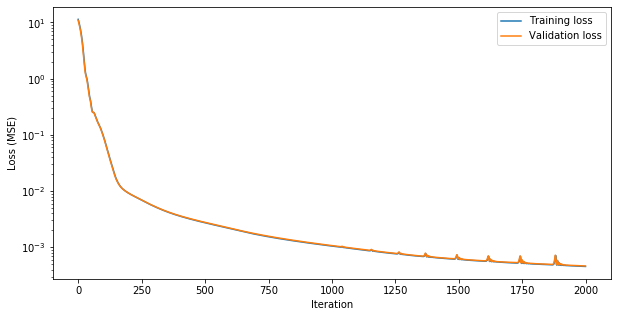

In [305]:
plt.figure(figsize=(10,5))
plt.semilogy(np_batched_loss_1,label='Training loss')
plt.semilogy(valid_loss,label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.legend()


## Investigate performance of each band of emulator
To visulise performance of the trainied emulator, I will show the difference between real and emulated for each band.

In [307]:
predictions = net_apply(net_params,validation_batch_X)

In [309]:
validation_batch_X.shape

(41, 1000, 3)

In [301]:
validation_batch_X[0,:,:].shape

(1000, 3)

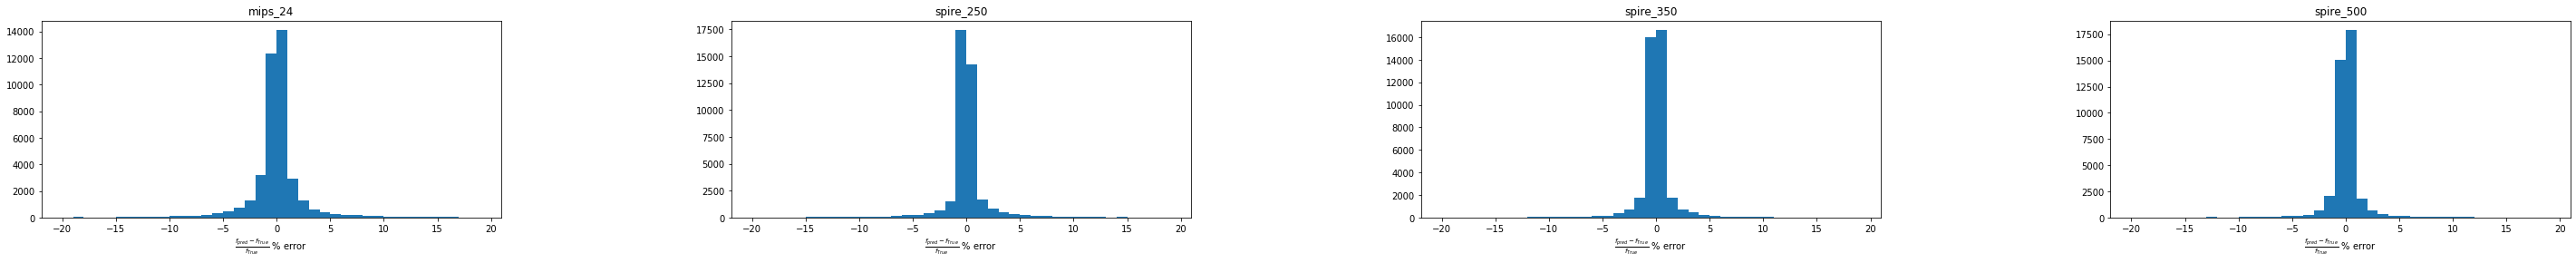

In [308]:
res=((predictions-validation_batch_Y)/validation_batch_Y)
fig,axes=plt.subplots(1,len(output_cols),figsize=(50,len(output_cols)))
for i in range(0,len(output_cols)):
    axes[i].hist(res[:,:,i].flatten()*100.0,np.arange(-20,20))
    axes[i].set_title(output_cols[i])
    axes[i].set_xlabel(r'$\frac{f_{pred} - f_{True}}{f_{True}} \ \%$ error')
plt.subplots_adjust(wspace=0.5)

## Save network
Having trained and validated network, I need to save the network and relevant functions

In [ ]:
import cloudpickle


In [ ]:
with open('CIGALE_emulator_20210303.pkl', 'wb') as f:
    cloudpickle.dump({'net_init':net_init,'net_apply': net_apply,'params':net_params}, f)
    
net_init, net_apply

## Does SED look right?

In [ ]:
net_apply(net_params,validation_batch_X)

In [310]:
validation_batch_X.shape

(41, 1000, 3)

In [315]:
wave=np.array([24,250,350,500])

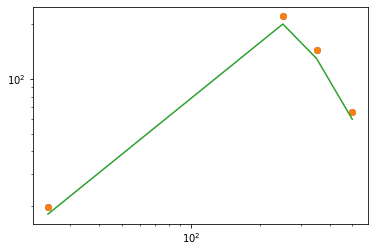

In [347]:
plt.loglog(wave,10.0**net_apply(net_params,np.array([3.0,0.5,0.0])),'o')
plt.loglog(wave,10.0**net_apply(net_params,np.array([3.0,0.5,0.0])),'o')
plt.loglog(wave,dataset[(dataset['universe.redshift']==1.0) & (dataset['agn.fracAGN'] == 0.5) & (dataset['sfh.sfr']>900) & (dataset['sfh.sfr']<1100)][output_cols].values())

In [342]:
validation_batch_Y[0,0,:]

DeviceArray([2.0539596, 2.6960201, 2.279064 , 1.8092766], dtype=float32)

In [343]:
predictions[0,0,:]

DeviceArray([2.0435352, 2.6978173, 2.2898817, 1.8142447], dtype=float32)

In [346]:
validation_batch_X[0,0,:]

DeviceArray([ 0.05644206,  0.05      , -1.8601209 ], dtype=float32)